# Module 4: Kaitlyn Jesmonth

In [1]:
import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from eofs.xarray import Eof 
import warnings
warnings.filterwarnings('ignore')

In [2]:
from dask.distributed import Client, progress

In [3]:
client = Client()  # set up local cluster on your laptop
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 5
Total threads: 20,Total memory: 7.63 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:46585,Workers: 5
Dashboard: http://127.0.0.1:8787/status,Total threads: 20
Started: Just now,Total memory: 7.63 GiB
Comm: tcp://127.0.0.1:36635,Total threads: 4
Dashboard: http://127.0.0.1:35529/status,Memory: 1.53 GiB
Nanny: tcp://127.0.0.1:35919,


## Problem 1

(1) Create a dataset that contains the monthly means of Sea Surface Temperature anomalies and total column water vapor from Jan 1979-Dec 2023 over the Pacific Basin (65°N to 65°S, 120°E to 60°W) masked out over land - save this to your computer.

### Create Masked SST Anomaly Dataset

In [4]:
# get the sst and total column wv data via the thredds server
ds = xr.open_dataset('https://thredds.rda.ucar.edu/thredds/dodsC/aggregations/g/ds633.1/2/TP',
                     chunks={'time':'500MB'})

variables = ['Total_column_water_vapour_surface_Mixed_intervals_Average',
             'Sea_surface_temperature_surface_Mixed_intervals_Average']
#select the two needed variables every 4th point to get 1 degree resolution
ds = ds[variables].sel(lat=slice(65, -65, 4), lon=slice(120, 300, 4))
ds

<xarray.Dataset>
Dimensions:                                                    (time: 516,
                                                                lat: 130,
                                                                lon: 181)
Coordinates:
  * lat                                                        (lat) float32 ...
  * lon                                                        (lon) float32 ...
  * time                                                       (time) datetime64[ns] ...
    reftime                                                    (time) datetime64[ns] dask.array<chunksize=(516,), meta=np.ndarray>
Data variables:
    Total_column_water_vapour_surface_Mixed_intervals_Average  (time, lat, lon) float32 dask.array<chunksize=(120, 130, 181), meta=np.ndarray>
    Sea_surface_temperature_surface_Mixed_intervals_Average    (time, lat, lon) float32 dask.array<chunksize=(120, 130, 181), meta=np.ndarray>
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

In [7]:
# save out data
ds.to_netcdf('raw_era5_data.nc')

In [8]:
# open data
raw_era5_ds = xr.open_dataset('raw_era5_data.nc')
raw_era5_ds

<xarray.Dataset>
Dimensions:                                                    (time: 516,
                                                                lat: 130,
                                                                lon: 181)
Coordinates:
  * lat                                                        (lat) float32 ...
  * lon                                                        (lon) float32 ...
  * time                                                       (time) datetime64[ns] ...
    reftime                                                    (time) datetime64[ns] ...
Data variables:
    Total_column_water_vapour_surface_Mixed_intervals_Average  (time, lat, lon) float32 ...
    Sea_surface_temperature_surface_Mixed_intervals_Average    (time, lat, lon) float32 ...
Attributes:
    Originating_or_generating_Center:     European Centre for Medium Range We...
    Originating_or_generating_Subcenter:  0
    GRIB_table_version:                   0,128
    file_format:                          GRIB-1
    Conventions:                          CF-1.6
    history:                              Read using CDM IOSP GribCollection v3
    featureType:                          GRID
    _CoordSysBuilder:                     ucar.nc2.dataset.conv.CF1Convention

In [9]:
# store the sst data as a data array
sstk_ds = raw_era5_ds['Sea_surface_temperature_surface_Mixed_intervals_Average']
sstk_ds

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             lat: 130,
                                                                             lon: 181)>
[12141480 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] ...
Attributes: (12/15)
    long_name:                       Sea surface temperature (Mixed_intervals...
    units:                           K
    description:                     v-component of wind
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Average
    Grib_Variable_Id:                VAR_98-0-128-34_L1_Imixed_S123
    ...                              ...
    Grib1_Parameter:                 34
    Grib1_Parameter_Name:            sst
    Grib1_Level_Type:                1
    Grib1_Level_Desc:                Ground or water surface
    Grib1_Interval_Type:             123
    Grib1_Interval_Name:             Average of N uninitialized analyses, int...

In [10]:
# compute monthly mean sst
sstk_grouped = sstk_ds.groupby('time.month')
monthly_sstk_mean = sstk_grouped.mean(dim='time')
monthly_sstk_mean

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             month: 12,
                                                                             lat: 130,
                                                                             lon: 181)>
array([[[      nan,       nan,       nan, ..., 271.46027, 271.4657 ,
         271.48868],
        [      nan,       nan,       nan, ..., 271.465  , 271.49216,
         271.71713],
        [      nan,       nan,       nan, ..., 271.49683, 271.7742 ,
         272.49863],
        ...,
        [274.4158 , 274.4608 , 274.48816, ..., 274.6157 , 274.59637,
         274.33667],
        [274.07883, 274.11722, 274.1361 , ..., 274.06668, 274.28864,
         273.508  ],
        [273.46783, 273.5089 , 273.53342, ..., 273.0764 , 272.3691 ,
               nan]],

       [[      nan,       nan,       nan, ..., 271.46008, 271.46017,
         271.46375],
        [      nan,       nan,       nan, ..., 271.46063, 271.467  ,
         271.59003],
        [      nan,       nan,       nan, ..., 271.47995, 271.64624,
         272.17206],
...
        [271.92252, 271.92776, 271.96426, ..., 272.3855 , 272.4379 ,
         272.41818],
        [271.707  , 271.76053, 271.78387, ..., 272.1689 , 272.44717,
         272.1106 ],
        [271.49426, 271.50845, 271.51993, ..., 272.04623, 271.64777,
               nan]],

       [[      nan,       nan,       nan, ..., 271.49014, 271.509  ,
         271.59924],
        [      nan,       nan,       nan, ..., 271.5423 , 271.65775,
         272.186  ],
        [      nan,       nan,       nan, ..., 271.74628, 272.38675,
         273.48538],
        ...,
        [273.01923, 273.0294 , 273.05228, ..., 273.6013 , 273.7123 ,
         273.548  ],
        [272.69177, 272.7608 , 272.79675, ..., 273.2362 , 273.52176,
         272.86057],
        [272.11423, 272.2133 , 272.2582 , ..., 272.8163 , 272.19785,
               nan]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes: (12/15)
    long_name:                       Sea surface temperature (Mixed_intervals...
    units:                           K
    description:                     v-component of wind
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Average
    Grib_Variable_Id:                VAR_98-0-128-34_L1_Imixed_S123
    ...                              ...
    Grib1_Parameter:                 34
    Grib1_Parameter_Name:            sst
    Grib1_Level_Type:                1
    Grib1_Level_Desc:                Ground or water surface
    Grib1_Interval_Type:             123
    Grib1_Interval_Name:             Average of N uninitialized analyses, int...

In [11]:
# compute monthly mean sst anomalies
sst_anomaly = sstk_grouped - monthly_sstk_mean
sst_anomaly

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             lat: 130,
                                                                             lon: 181)>
array([[[            nan,             nan,             nan, ...,
         -6.10351562e-05, -5.49316406e-03, -2.74963379e-02],
        [            nan,             nan,             nan, ...,
         -4.79125977e-03, -8.51440430e-03,  4.27642822e-01],
        [            nan,             nan,             nan, ...,
          5.51757812e-02,  5.39520264e-01,  9.44976807e-01],
        ...,
        [ 1.35223389e-01, -3.28063965e-02, -4.55322266e-02, ...,
         -4.92401123e-01, -3.81286621e-01, -1.84082031e-01],
        [-3.11004639e-01, -3.59161377e-01, -4.45434570e-01, ...,
         -3.16436768e-01, -1.69250488e-01,  3.04748535e-01],
        [-4.18762207e-01, -4.44213867e-01, -5.34149170e-01, ...,
         -9.46258545e-01, -9.27459717e-01,             nan]],

       [[            nan,             nan,             nan, ...,
          1.22070312e-04,  3.05175781e-05, -3.54003906e-03],
        [            nan,             nan,             nan, ...,
         -4.27246094e-04, -3.87573242e-03,  3.00842285e-01],
        [            nan,             nan,             nan, ...,
          3.20129395e-02,  6.05957031e-01,  9.84436035e-01],
...
          4.84130859e-01,  7.63763428e-01,  8.17657471e-01],
        [-2.38952637e-02,  9.54284668e-02,  2.41027832e-01, ...,
          7.51495361e-01,  6.52923584e-01,  5.20751953e-01],
        [-3.38134766e-02, -4.80041504e-02, -5.94787598e-02, ...,
          9.58160400e-01,  3.39050293e-01,             nan]],

       [[            nan,             nan,             nan, ...,
          9.04235840e-02,  9.10949707e-02,  3.11279297e-02],
        [            nan,             nan,             nan, ...,
          8.31909180e-02,  6.24694824e-02,  3.48663330e-01],
        [            nan,             nan,             nan, ...,
          3.44848633e-02,  4.78973389e-01,  9.03778076e-01],
        ...,
        [-1.02722168e-01, -9.14001465e-02, -1.16241455e-01, ...,
          2.71301270e-02,  1.79779053e-01,  3.20648193e-01],
        [ 9.97314453e-02,  5.60913086e-02,  9.72900391e-02, ...,
          3.27758789e-01,  1.61346436e-01,  1.53594971e-01],
        [-6.31713867e-03,  3.32946777e-02,  1.29974365e-01, ...,
          9.72259521e-01,  6.06353760e-01,             nan]]],
      dtype=float32)
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [12]:
# rename coordinate to latitude and longitude to match the mask dataset
sst_anomaly = sst_anomaly.rename({'lat': 'latitude', 'lon':'longitude'})
sst_anomaly

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             latitude: 130,
                                                                             longitude: 181)>
array([[[            nan,             nan,             nan, ...,
         -6.10351562e-05, -5.49316406e-03, -2.74963379e-02],
        [            nan,             nan,             nan, ...,
         -4.79125977e-03, -8.51440430e-03,  4.27642822e-01],
        [            nan,             nan,             nan, ...,
          5.51757812e-02,  5.39520264e-01,  9.44976807e-01],
        ...,
        [ 1.35223389e-01, -3.28063965e-02, -4.55322266e-02, ...,
         -4.92401123e-01, -3.81286621e-01, -1.84082031e-01],
        [-3.11004639e-01, -3.59161377e-01, -4.45434570e-01, ...,
         -3.16436768e-01, -1.69250488e-01,  3.04748535e-01],
        [-4.18762207e-01, -4.44213867e-01, -5.34149170e-01, ...,
         -9.46258545e-01, -9.27459717e-01,             nan]],

       [[            nan,             nan,             nan, ...,
          1.22070312e-04,  3.05175781e-05, -3.54003906e-03],
        [            nan,             nan,             nan, ...,
         -4.27246094e-04, -3.87573242e-03,  3.00842285e-01],
        [            nan,             nan,             nan, ...,
          3.20129395e-02,  6.05957031e-01,  9.84436035e-01],
...
          4.84130859e-01,  7.63763428e-01,  8.17657471e-01],
        [-2.38952637e-02,  9.54284668e-02,  2.41027832e-01, ...,
          7.51495361e-01,  6.52923584e-01,  5.20751953e-01],
        [-3.38134766e-02, -4.80041504e-02, -5.94787598e-02, ...,
          9.58160400e-01,  3.39050293e-01,             nan]],

       [[            nan,             nan,             nan, ...,
          9.04235840e-02,  9.10949707e-02,  3.11279297e-02],
        [            nan,             nan,             nan, ...,
          8.31909180e-02,  6.24694824e-02,  3.48663330e-01],
        [            nan,             nan,             nan, ...,
          3.44848633e-02,  4.78973389e-01,  9.03778076e-01],
        ...,
        [-1.02722168e-01, -9.14001465e-02, -1.16241455e-01, ...,
          2.71301270e-02,  1.79779053e-01,  3.20648193e-01],
        [ 9.97314453e-02,  5.60913086e-02,  9.72900391e-02, ...,
          3.27758789e-01,  1.61346436e-01,  1.53594971e-01],
        [-6.31713867e-03,  3.32946777e-02,  1.29974365e-01, ...,
          9.72259521e-01,  6.06353760e-01,             nan]]],
      dtype=float32)
Coordinates:
  * latitude   (latitude) float32 64.75 63.75 62.75 ... -62.25 -63.25 -64.25
  * longitude  (longitude) float32 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime    (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [13]:
# round latitudes to match coordinates of the mask
sst_anomaly['latitude'] = sst_anomaly['latitude'].round()
sst_anomaly

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             latitude: 130,
                                                                             longitude: 181)>
array([[[            nan,             nan,             nan, ...,
         -6.10351562e-05, -5.49316406e-03, -2.74963379e-02],
        [            nan,             nan,             nan, ...,
         -4.79125977e-03, -8.51440430e-03,  4.27642822e-01],
        [            nan,             nan,             nan, ...,
          5.51757812e-02,  5.39520264e-01,  9.44976807e-01],
        ...,
        [ 1.35223389e-01, -3.28063965e-02, -4.55322266e-02, ...,
         -4.92401123e-01, -3.81286621e-01, -1.84082031e-01],
        [-3.11004639e-01, -3.59161377e-01, -4.45434570e-01, ...,
         -3.16436768e-01, -1.69250488e-01,  3.04748535e-01],
        [-4.18762207e-01, -4.44213867e-01, -5.34149170e-01, ...,
         -9.46258545e-01, -9.27459717e-01,             nan]],

       [[            nan,             nan,             nan, ...,
          1.22070312e-04,  3.05175781e-05, -3.54003906e-03],
        [            nan,             nan,             nan, ...,
         -4.27246094e-04, -3.87573242e-03,  3.00842285e-01],
        [            nan,             nan,             nan, ...,
          3.20129395e-02,  6.05957031e-01,  9.84436035e-01],
...
          4.84130859e-01,  7.63763428e-01,  8.17657471e-01],
        [-2.38952637e-02,  9.54284668e-02,  2.41027832e-01, ...,
          7.51495361e-01,  6.52923584e-01,  5.20751953e-01],
        [-3.38134766e-02, -4.80041504e-02, -5.94787598e-02, ...,
          9.58160400e-01,  3.39050293e-01,             nan]],

       [[            nan,             nan,             nan, ...,
          9.04235840e-02,  9.10949707e-02,  3.11279297e-02],
        [            nan,             nan,             nan, ...,
          8.31909180e-02,  6.24694824e-02,  3.48663330e-01],
        [            nan,             nan,             nan, ...,
          3.44848633e-02,  4.78973389e-01,  9.03778076e-01],
        ...,
        [-1.02722168e-01, -9.14001465e-02, -1.16241455e-01, ...,
          2.71301270e-02,  1.79779053e-01,  3.20648193e-01],
        [ 9.97314453e-02,  5.60913086e-02,  9.72900391e-02, ...,
          3.27758789e-01,  1.61346436e-01,  1.53594971e-01],
        [-6.31713867e-03,  3.32946777e-02,  1.29974365e-01, ...,
          9.72259521e-01,  6.06353760e-01,             nan]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime    (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float32 65.0 64.0 63.0 62.0 ... -62.0 -63.0 -64.0

#### Mask the SST anomaly data

In [14]:
# get the mask dataset via the thredds server
mask_url = 'https://thredds.rda.ucar.edu/thredds/dodsC/files/g/ds633.0/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc'
ls_mask = xr.open_dataset(mask_url).sel(latitude=slice(65, -65, 4),longitude=slice(120, 300, 4)).compute()
ls_mask

<xarray.Dataset>
Dimensions:    (latitude: 131, longitude: 181, time: 1)
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -63.0 -64.0 -65.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-01
Data variables:
    utc_date   (time) int32 1979010100
    LSM        (time, latitude, longitude) float32 0.9839 0.9778 ... 0.9546
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.6.1|hdf5lib...
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB1 da...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper04 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon May 13 18:10:35 MDT 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon May 13 18:10:35 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.4 (http://n...
    DODS_EXTRA.Unlimited_Dimension:  time

In [15]:
# drop last latitude value to match coordinates
ls_mask = ls_mask.where(ls_mask.latitude!=-65., drop=True)
ls_mask

<xarray.Dataset>
Dimensions:    (time: 1, latitude: 130, longitude: 181)
Coordinates:
  * latitude   (latitude) float64 65.0 64.0 63.0 62.0 ... -62.0 -63.0 -64.0
  * longitude  (longitude) float64 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-01
Data variables:
    utc_date   (time, latitude) float64 1.979e+09 1.979e+09 ... 1.979e+09
    LSM        (time, latitude, longitude) float32 0.9839 0.9778 ... 0.7264
Attributes:
    _NCProperties:                   version=1|netcdflibversion=4.6.1|hdf5lib...
    DATA_SOURCE:                     ECMWF: https://cds.climate.copernicus.eu...
    NETCDF_CONVERSION:               CISL RDA: Conversion from ECMWF GRIB1 da...
    NETCDF_VERSION:                  4.6.1
    CONVERSION_PLATFORM:             Linux casper04 3.10.0-693.21.1.el7.x86_6...
    CONVERSION_DATE:                 Mon May 13 18:10:35 MDT 2019
    Conventions:                     CF-1.6
    NETCDF_COMPRESSION:              NCO: Precision-preserving compression to...
    history:                         Mon May 13 18:10:35 2019: ncks -4 --ppc ...
    NCO:                             netCDF Operators version 4.7.4 (http://n...
    DODS_EXTRA.Unlimited_Dimension:  time

In [16]:
# mask out sea surface temperature anomalies data using land mask
mask_squeezed = ls_mask.squeeze('time')
mask_time = mask_squeezed.expand_dims(time=sst_anomaly.time)
mask_sst_anomaly = sst_anomaly.where(mask_time.LSM==0., np.nan)
mask_sst_anomaly

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             latitude: 130,
                                                                             longitude: 181)>
array([[[            nan,             nan,             nan, ...,
         -6.10351562e-05, -5.49316406e-03, -2.74963379e-02],
        [            nan,             nan,             nan, ...,
         -4.79125977e-03, -8.51440430e-03,  4.27642822e-01],
        [            nan,             nan,             nan, ...,
          5.51757812e-02,  5.39520264e-01,  9.44976807e-01],
        ...,
        [ 1.35223389e-01, -3.28063965e-02, -4.55322266e-02, ...,
         -4.92401123e-01, -3.81286621e-01,             nan],
        [-3.11004639e-01, -3.59161377e-01, -4.45434570e-01, ...,
                     nan,             nan,             nan],
        [-4.18762207e-01, -4.44213867e-01, -5.34149170e-01, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
          1.22070312e-04,  3.05175781e-05, -3.54003906e-03],
        [            nan,             nan,             nan, ...,
         -4.27246094e-04, -3.87573242e-03,  3.00842285e-01],
        [            nan,             nan,             nan, ...,
          3.20129395e-02,  6.05957031e-01,  9.84436035e-01],
...
          4.84130859e-01,  7.63763428e-01,             nan],
        [-2.38952637e-02,  9.54284668e-02,  2.41027832e-01, ...,
                     nan,             nan,             nan],
        [-3.38134766e-02, -4.80041504e-02, -5.94787598e-02, ...,
                     nan,             nan,             nan]],

       [[            nan,             nan,             nan, ...,
          9.04235840e-02,  9.10949707e-02,  3.11279297e-02],
        [            nan,             nan,             nan, ...,
          8.31909180e-02,  6.24694824e-02,  3.48663330e-01],
        [            nan,             nan,             nan, ...,
          3.44848633e-02,  4.78973389e-01,  9.03778076e-01],
        ...,
        [-1.02722168e-01, -9.14001465e-02, -1.16241455e-01, ...,
          2.71301270e-02,  1.79779053e-01,             nan],
        [ 9.97314453e-02,  5.60913086e-02,  9.72900391e-02, ...,
                     nan,             nan,             nan],
        [-6.31713867e-03,  3.32946777e-02,  1.29974365e-01, ...,
                     nan,             nan,             nan]]],
      dtype=float32)
Coordinates:
  * longitude  (longitude) float32 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime    (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float32 65.0 64.0 63.0 62.0 ... -62.0 -63.0 -64.0

### Plotting Example

In [17]:
# Pacific Basin Box
lon_W = 360-60
lon_E = 120
lat_N = 65
lat_S = -65

In [18]:
# get sea surface temperature anomalies for a given day (representing a month) to plot
plot_sst_anomaly = mask_sst_anomaly.sel(time='2020-12-01', method='nearest')
plot_sst_anomaly.time.values

numpy.datetime64('2020-11-16T00:00:00.000000000')

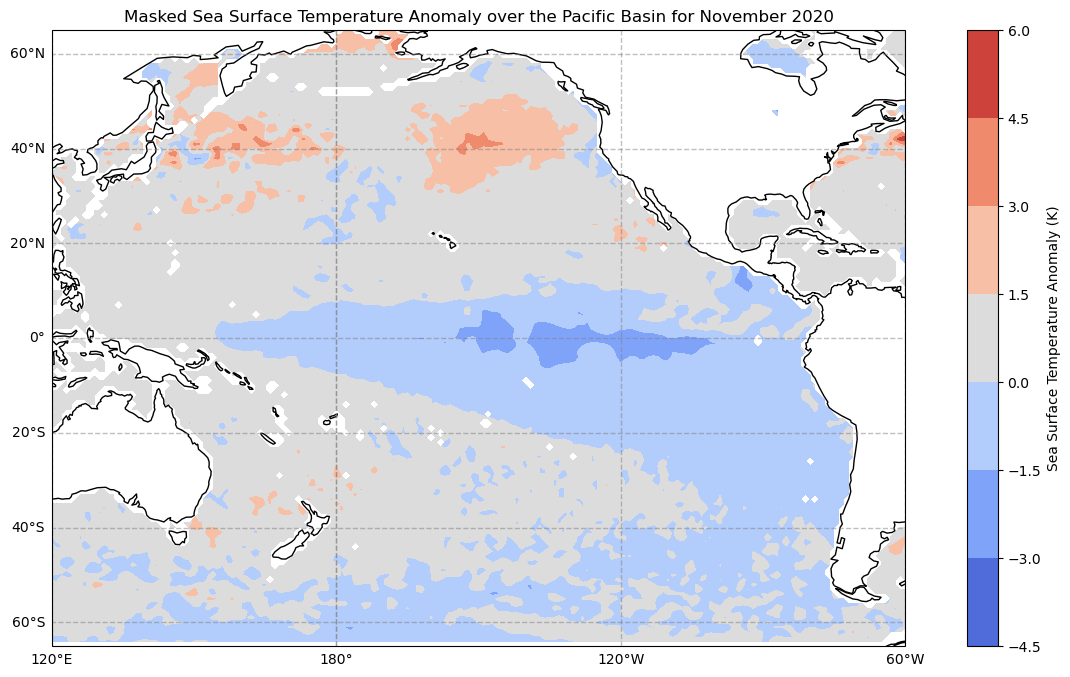

In [19]:
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# set the title, add gridlines, features, and set the extent
ax.set_title('Masked Sea Surface Temperature Anomaly over the Pacific Basin for November 2020')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',  crs=ccrs.PlateCarree())
gl.top_labels = False
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([lon_E, lon_W, lat_N, lat_S], crs=ccrs.PlateCarree())

# plot the data
sstk_cf = ax.contourf(plot_sst_anomaly.longitude, plot_sst_anomaly.latitude, plot_sst_anomaly, transform=ccrs.PlateCarree(), cmap=plt.cm.coolwarm)

# specify the colorbar
cbar = plt.colorbar(sstk_cf)
cbar.set_label('Sea Surface Temperature Anomaly (K)') 

### Create Masked Total Column Water Vapor Anomaly Dataset

In [20]:
# store the wv data as a data array
column_wv_ds = raw_era5_ds['Total_column_water_vapour_surface_Mixed_intervals_Average']
column_wv_ds

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               time: 516,
                                                                               lat: 130,
                                                                               lon: 181)>
[12141480 values with dtype=float32]
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] ...
Attributes: (12/14)
    long_name:                       Total column water vapour (Mixed_interva...
    units:                           kg m**-2
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Average
    Grib_Variable_Id:                VAR_98-0-128-137_L1_Imixed_S123
    Grib1_Center:                    98
    ...                              ...
    Grib1_Parameter:                 137
    Grib1_Parameter_Name:            tcwv
    Grib1_Level_Type:                1
    Grib1_Level_Desc:                Ground or water surface
    Grib1_Interval_Type:             123
    Grib1_Interval_Name:             Average of N uninitialized analyses, int...

In [21]:
# compute monthly mean wv
column_wv_grouped = column_wv_ds.groupby('time.month')
monthly_wv_mean = column_wv_grouped.mean(dim='time')
monthly_wv_mean

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               month: 12,
                                                                               lat: 130,
                                                                               lon: 181)>
array([[[ 1.9425216,  1.9193339,  1.8866531, ...,  2.609741 ,
          2.6983354,  2.8085961],
        [ 1.9902369,  1.9767239,  1.9529912, ...,  2.7416222,
          2.851497 ,  3.0007744],
        [ 1.983946 ,  1.9563979,  1.9220364, ...,  2.9226494,
          3.061503 ,  3.2334917],
        ...,
        [ 8.868325 ,  8.923876 ,  8.982742 , ...,  9.971068 ,
          9.8896055,  9.756815 ],
        [ 8.563843 ,  8.62146  ,  8.677737 , ...,  9.425239 ,
          9.45726  ,  9.305393 ],
        [ 8.222363 ,  8.2664   ,  8.31039  , ...,  8.912566 ,
          6.7482533,  5.0555296]],

       [[ 2.003886 ,  1.974998 ,  1.9373891, ...,  2.419834 ,
          2.4895785,  2.5737448],
        [ 2.0726545,  2.0516925,  2.0225317, ...,  2.5472186,
          2.6370394,  2.7577243],
        [ 2.0664318,  2.029345 ,  1.982629 , ...,  2.715369 ,
          2.8362126,  2.9875796],
...
        [ 6.563363 ,  6.590389 ,  6.6199355, ...,  7.888694 ,
          7.845658 ,  7.754315 ],
        [ 6.1643577,  6.197311 ,  6.2258806, ...,  7.4268026,
          7.461618 ,  7.33244  ],
        [ 5.728583 ,  5.7626266,  5.793604 , ...,  6.936637 ,
          5.164607 ,  3.710846 ]],

       [[ 2.154884 ,  2.1172523,  2.0732162, ...,  3.4635012,
          3.5612712,  3.6849766],
        [ 2.226968 ,  2.2017138,  2.1644907, ...,  3.6494796,
          3.768121 ,  3.9243028],
        [ 2.230352 ,  2.1906536,  2.141621 , ...,  3.8618484,
          4.00722  ,  4.185341 ],
        ...,
        [ 8.015258 ,  8.05096  ,  8.090772 , ...,  8.802958 ,
          8.746135 ,  8.634534 ],
        [ 7.7244244,  7.7580585,  7.7899675, ...,  8.348174 ,
          8.400137 ,  8.265848 ],
        [ 7.407315 ,  7.4356575,  7.4586864, ...,  7.9122195,
          5.9817166,  4.4353857]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Attributes: (12/14)
    long_name:                       Total column water vapour (Mixed_interva...
    units:                           kg m**-2
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Average
    Grib_Variable_Id:                VAR_98-0-128-137_L1_Imixed_S123
    Grib1_Center:                    98
    ...                              ...
    Grib1_Parameter:                 137
    Grib1_Parameter_Name:            tcwv
    Grib1_Level_Type:                1
    Grib1_Level_Desc:                Ground or water surface
    Grib1_Interval_Type:             123
    Grib1_Interval_Name:             Average of N uninitialized analyses, int...

In [22]:
# compute monthly mean wv anomalies
wv_anomaly = column_wv_grouped - monthly_wv_mean
wv_anomaly

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               time: 516,
                                                                               lat: 130,
                                                                               lon: 181)>
array([[[-0.84616494, -0.78000855, -0.7082652 , ...,  1.3655219 ,
          1.4234116 ,  1.4801431 ],
        [-0.9114584 , -0.8559532 , -0.7970643 , ...,  1.3566873 ,
          1.4274766 ,  1.4940195 ],
        [-0.9383706 , -0.87176   , -0.8120079 , ...,  1.4002695 ,
          1.4743066 ,  1.53181   ],
        ...,
        [-1.0893517 , -1.1195116 , -1.1979094 , ...,  0.8411083 ,
          0.7272587 ,  0.5954008 ],
        [-1.202838  , -1.2145567 , -1.2044277 , ...,  0.54123497,
          0.42132282,  0.27924442],
        [-1.1670227 , -1.1710205 , -1.15837   , ...,  0.5177746 ,
          0.35884523,  0.25274086]],

       [[-0.6710856 , -0.6402445 , -0.60458875, ...,  0.733279  ,
          0.89888597,  1.0363994 ],
        [-0.61094785, -0.58705616, -0.5637548 , ...,  0.88616776,
          1.1147063 ,  1.3690214 ],
        [-0.5031626 , -0.48756027, -0.476977  , ...,  1.1525877 ,
          1.469244  ,  1.7221739 ],
...
        [-1.2091408 , -1.1922212 , -1.1621976 , ...,  0.41767693,
          0.41286135,  0.41338396],
        [-1.1773229 , -1.1702371 , -1.1587677 , ...,  0.59929466,
          0.6074481 ,  0.5325246 ],
        [-1.1311965 , -1.130084  , -1.0917253 , ...,  0.6558666 ,
          0.4122715 ,  0.17950916]],

       [[-0.42648733, -0.42596495, -0.4161085 , ...,  1.0607941 ,
          1.124157  ,  1.2514281 ],
        [-0.43997753, -0.45378578, -0.45660174, ...,  0.95196414,
          1.0364478 ,  1.1419847 ],
        [-0.42675984, -0.42905366, -0.43177903, ...,  0.87436104,
          0.9760599 ,  1.0469623 ],
        ...,
        [ 0.6105995 ,  0.6500931 ,  0.63957787, ...,  0.34633732,
          0.35433197,  0.36339378],
        [ 0.6699877 ,  0.5299082 ,  0.346632  , ...,  0.37143326,
          0.34779072,  0.302392  ],
        [ 0.05155087, -0.11936998, -0.30548477, ...,  0.4694972 ,
          0.34628963,  0.13480806]]], dtype=float32)
Coordinates:
  * lat      (lat) float32 64.75 63.75 62.75 61.75 ... -62.25 -63.25 -64.25
  * lon      (lon) float32 120.0 121.0 122.0 123.0 ... 297.0 298.0 299.0 300.0
  * time     (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime  (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [23]:
# rename coordinate to latitude and longitude to match the mask dataset
wv_anomaly = wv_anomaly.rename({'lat': 'latitude', 'lon':'longitude'})
wv_anomaly

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               time: 516,
                                                                               latitude: 130,
                                                                               longitude: 181)>
array([[[-0.84616494, -0.78000855, -0.7082652 , ...,  1.3655219 ,
          1.4234116 ,  1.4801431 ],
        [-0.9114584 , -0.8559532 , -0.7970643 , ...,  1.3566873 ,
          1.4274766 ,  1.4940195 ],
        [-0.9383706 , -0.87176   , -0.8120079 , ...,  1.4002695 ,
          1.4743066 ,  1.53181   ],
        ...,
        [-1.0893517 , -1.1195116 , -1.1979094 , ...,  0.8411083 ,
          0.7272587 ,  0.5954008 ],
        [-1.202838  , -1.2145567 , -1.2044277 , ...,  0.54123497,
          0.42132282,  0.27924442],
        [-1.1670227 , -1.1710205 , -1.15837   , ...,  0.5177746 ,
          0.35884523,  0.25274086]],

       [[-0.6710856 , -0.6402445 , -0.60458875, ...,  0.733279  ,
          0.89888597,  1.0363994 ],
        [-0.61094785, -0.58705616, -0.5637548 , ...,  0.88616776,
          1.1147063 ,  1.3690214 ],
        [-0.5031626 , -0.48756027, -0.476977  , ...,  1.1525877 ,
          1.469244  ,  1.7221739 ],
...
        [-1.2091408 , -1.1922212 , -1.1621976 , ...,  0.41767693,
          0.41286135,  0.41338396],
        [-1.1773229 , -1.1702371 , -1.1587677 , ...,  0.59929466,
          0.6074481 ,  0.5325246 ],
        [-1.1311965 , -1.130084  , -1.0917253 , ...,  0.6558666 ,
          0.4122715 ,  0.17950916]],

       [[-0.42648733, -0.42596495, -0.4161085 , ...,  1.0607941 ,
          1.124157  ,  1.2514281 ],
        [-0.43997753, -0.45378578, -0.45660174, ...,  0.95196414,
          1.0364478 ,  1.1419847 ],
        [-0.42675984, -0.42905366, -0.43177903, ...,  0.87436104,
          0.9760599 ,  1.0469623 ],
        ...,
        [ 0.6105995 ,  0.6500931 ,  0.63957787, ...,  0.34633732,
          0.35433197,  0.36339378],
        [ 0.6699877 ,  0.5299082 ,  0.346632  , ...,  0.37143326,
          0.34779072,  0.302392  ],
        [ 0.05155087, -0.11936998, -0.30548477, ...,  0.4694972 ,
          0.34628963,  0.13480806]]], dtype=float32)
Coordinates:
  * latitude   (latitude) float32 64.75 63.75 62.75 ... -62.25 -63.25 -64.25
  * longitude  (longitude) float32 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime    (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12

In [24]:
# round latitudes to match coordinates of the mask
wv_anomaly['latitude'] = wv_anomaly['latitude'].round()
wv_anomaly

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               time: 516,
                                                                               latitude: 130,
                                                                               longitude: 181)>
array([[[-0.84616494, -0.78000855, -0.7082652 , ...,  1.3655219 ,
          1.4234116 ,  1.4801431 ],
        [-0.9114584 , -0.8559532 , -0.7970643 , ...,  1.3566873 ,
          1.4274766 ,  1.4940195 ],
        [-0.9383706 , -0.87176   , -0.8120079 , ...,  1.4002695 ,
          1.4743066 ,  1.53181   ],
        ...,
        [-1.0893517 , -1.1195116 , -1.1979094 , ...,  0.8411083 ,
          0.7272587 ,  0.5954008 ],
        [-1.202838  , -1.2145567 , -1.2044277 , ...,  0.54123497,
          0.42132282,  0.27924442],
        [-1.1670227 , -1.1710205 , -1.15837   , ...,  0.5177746 ,
          0.35884523,  0.25274086]],

       [[-0.6710856 , -0.6402445 , -0.60458875, ...,  0.733279  ,
          0.89888597,  1.0363994 ],
        [-0.61094785, -0.58705616, -0.5637548 , ...,  0.88616776,
          1.1147063 ,  1.3690214 ],
        [-0.5031626 , -0.48756027, -0.476977  , ...,  1.1525877 ,
          1.469244  ,  1.7221739 ],
...
        [-1.2091408 , -1.1922212 , -1.1621976 , ...,  0.41767693,
          0.41286135,  0.41338396],
        [-1.1773229 , -1.1702371 , -1.1587677 , ...,  0.59929466,
          0.6074481 ,  0.5325246 ],
        [-1.1311965 , -1.130084  , -1.0917253 , ...,  0.6558666 ,
          0.4122715 ,  0.17950916]],

       [[-0.42648733, -0.42596495, -0.4161085 , ...,  1.0607941 ,
          1.124157  ,  1.2514281 ],
        [-0.43997753, -0.45378578, -0.45660174, ...,  0.95196414,
          1.0364478 ,  1.1419847 ],
        [-0.42675984, -0.42905366, -0.43177903, ...,  0.87436104,
          0.9760599 ,  1.0469623 ],
        ...,
        [ 0.6105995 ,  0.6500931 ,  0.63957787, ...,  0.34633732,
          0.35433197,  0.36339378],
        [ 0.6699877 ,  0.5299082 ,  0.346632  , ...,  0.37143326,
          0.34779072,  0.302392  ],
        [ 0.05155087, -0.11936998, -0.30548477, ...,  0.4694972 ,
          0.34628963,  0.13480806]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime    (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float32 65.0 64.0 63.0 62.0 ... -62.0 -63.0 -64.0

#### Mask the Total Column Water Vapor Dataset

In [25]:
# mask out total column water vapor anomalies data using land mask
mask_squeezed = ls_mask.squeeze('time')
mask_time = mask_squeezed.expand_dims(time=wv_anomaly.time)
mask_wv_anomaly = wv_anomaly.where(mask_time.LSM==0., np.nan)
mask_wv_anomaly

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               time: 516,
                                                                               latitude: 130,
                                                                               longitude: 181)>
array([[[        nan,         nan,         nan, ...,  1.3655219 ,
          1.4234116 ,  1.4801431 ],
        [        nan,         nan,         nan, ...,  1.3566873 ,
          1.4274766 ,  1.4940195 ],
        [        nan,         nan,         nan, ...,  1.4002695 ,
          1.4743066 ,  1.53181   ],
        ...,
        [-1.0893517 , -1.1195116 , -1.1979094 , ...,  0.8411083 ,
          0.7272587 ,         nan],
        [-1.202838  , -1.2145567 , -1.2044277 , ...,         nan,
                 nan,         nan],
        [-1.1670227 , -1.1710205 , -1.15837   , ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  0.733279  ,
          0.89888597,  1.0363994 ],
        [        nan,         nan,         nan, ...,  0.88616776,
          1.1147063 ,  1.3690214 ],
        [        nan,         nan,         nan, ...,  1.1525877 ,
          1.469244  ,  1.7221739 ],
...
        [-1.2091408 , -1.1922212 , -1.1621976 , ...,  0.41767693,
          0.41286135,         nan],
        [-1.1773229 , -1.1702371 , -1.1587677 , ...,         nan,
                 nan,         nan],
        [-1.1311965 , -1.130084  , -1.0917253 , ...,         nan,
                 nan,         nan]],

       [[        nan,         nan,         nan, ...,  1.0607941 ,
          1.124157  ,  1.2514281 ],
        [        nan,         nan,         nan, ...,  0.95196414,
          1.0364478 ,  1.1419847 ],
        [        nan,         nan,         nan, ...,  0.87436104,
          0.9760599 ,  1.0469623 ],
        ...,
        [ 0.6105995 ,  0.6500931 ,  0.63957787, ...,  0.34633732,
          0.35433197,         nan],
        [ 0.6699877 ,  0.5299082 ,  0.346632  , ...,         nan,
                 nan,         nan],
        [ 0.05155087, -0.11936998, -0.30548477, ...,         nan,
                 nan,         nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime    (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float32 65.0 64.0 63.0 62.0 ... -62.0 -63.0 -64.0

#### Plotting Example

In [26]:
# get water vapor anomalies for a given day (representing a month) to plot
plot_wv_anomaly = mask_wv_anomaly.sel(time='2020-11-01', method='nearest')
plot_wv_anomaly.time.values

numpy.datetime64('2020-11-16T00:00:00.000000000')

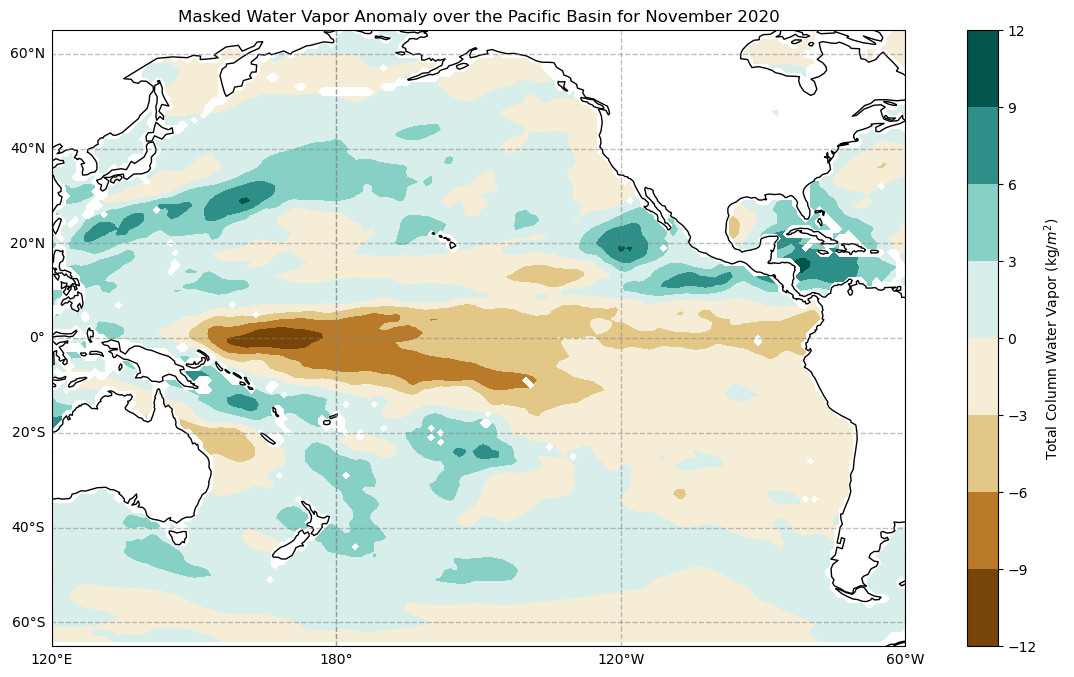

In [27]:
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# set the title, add gridlines, features, and set the extent
ax.set_title('Masked Water Vapor Anomaly over the Pacific Basin for November 2020')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',  crs=ccrs.PlateCarree())
gl.top_labels = False
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([lon_E, lon_W, lat_N, lat_S], crs=ccrs.PlateCarree())

# plot the data
sstk_cf = ax.contourf(plot_wv_anomaly.longitude, plot_wv_anomaly.latitude, plot_wv_anomaly, transform=ccrs.PlateCarree(), cmap=plt.cm.BrBG)

# specify the colorbar
cbar = plt.colorbar(sstk_cf)
cbar.set_label('Total Column Water Vapor (kg/$m^2$)') 

#### Merge Both Masked Datasets and Save Locally

In [28]:
# merge the masked sst and wv anomaly data and rename the variables
merged_masks = xr.merge([mask_sst_anomaly, mask_wv_anomaly])
merged_masks = merged_masks.rename({'Sea_surface_temperature_surface_Mixed_intervals_Average': 'Masked_SST_Anomalies', 
                                    'Total_column_water_vapour_surface_Mixed_intervals_Average': 'Masked_Total_Column_WV_Anomalies'})
merged_masks

<xarray.Dataset>
Dimensions:                           (longitude: 181, time: 516, latitude: 130)
Coordinates:
  * longitude                         (longitude) float32 120.0 121.0 ... 300.0
  * time                              (time) datetime64[ns] 1979-01-16T12:00:...
    reftime                           (time) datetime64[ns] 1979-01-01 ... 20...
    month                             (time) int64 1 2 3 4 5 6 ... 8 9 10 11 12
  * latitude                          (latitude) float32 65.0 64.0 ... -64.0
Data variables:
    Masked_SST_Anomalies              (time, latitude, longitude) float32 nan...
    Masked_Total_Column_WV_Anomalies  (time, latitude, longitude) float32 nan...

In [29]:
# save out data
merged_masks.to_netcdf('masked_sst_wv_anomaly.nc')

## Problem 2

(2) From the dataset shown in 1, compute anomalies by deseasonalizing the data (remove the mean monthly anomaly from the annual mean from each point), detrend, and standardize the SST anomalies.

### Deseasonalizing

In [30]:
# open saved masked data
#masked_sst_wv_anomaly = xr.open_dataset('masked_sst_wv_anomaly.nc')
#masked_sst_wv_anomaly

In [31]:
# compute deseasonalized sst anomalies (using unmasked sst anomalies computed in part 1)
sst_anom_grouped = sst_anomaly.groupby('time.month')
sst_anom_monthly_mean = sst_anom_grouped.mean(dim='time')
deseasonalized_sst_anom = sst_anom_grouped - sst_anom_monthly_mean
deseasonalized_sst_anom

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             latitude: 130,
                                                                             longitude: 181)>
array([[[           nan,            nan,            nan, ...,
         -7.3809955e-05, -5.4789698e-03, -2.7485693e-02],
        [           nan,            nan,            nan, ...,
         -4.7976472e-03, -8.5222116e-03,  4.2766055e-01],
        [           nan,            nan,            nan, ...,
          5.5181459e-02,  5.3955644e-01,  9.4498885e-01],
        ...,
        [ 1.3525958e-01, -3.2777298e-02, -4.5518033e-02, ...,
         -4.9239758e-01, -3.8125113e-01, -1.8405364e-01],
        [-3.1100675e-01, -3.5915357e-01, -4.4543174e-01, ...,
         -3.1641194e-01, -1.6924623e-01,  3.0477268e-01],
        [-4.1876930e-01, -4.4420534e-01, -5.3416264e-01, ...,
         -9.4627202e-01, -9.2742211e-01,            nan]],

       [[           nan,            nan,            nan, ...,
          1.3626454e-04,  4.5421511e-05, -3.4974564e-03],
        [           nan,            nan,            nan, ...,
         -4.0879360e-04, -3.8381177e-03,  3.0089480e-01],
        [           nan,            nan,            nan, ...,
          3.2044876e-02,  6.0599113e-01,  9.8448855e-01],
...
        [ 2.8406045e-01,  2.8862533e-01,  2.4229537e-01, ...,
          4.8411950e-01,  7.6375705e-01,  8.1764966e-01],
        [-2.3806550e-02,  9.5470339e-02,  2.4100086e-01, ...,
          7.5147051e-01,  6.5292853e-01,  5.2072924e-01],
        [-3.3799283e-02, -4.7993504e-02, -5.9485149e-02, ...,
          9.5816112e-01,  3.3908862e-01,            nan]],

       [[           nan,            nan,            nan, ...,
          9.0400167e-02,  9.1081485e-02,  3.1147802e-02],
        [           nan,            nan,            nan, ...,
          8.3155431e-02,  6.2488645e-02,  3.4866688e-01],
        [           nan,            nan,            nan, ...,
          3.4486283e-02,  4.7893578e-01,  9.0374047e-01],
        ...,
        [-1.0273211e-01, -9.1444857e-02, -1.1626771e-01, ...,
          2.7173419e-02,  1.7974427e-01,  3.2064182e-01],
        [ 9.9756993e-02,  5.6061503e-02,  9.7304232e-02, ...,
          3.2775027e-01,  1.6137128e-01,  1.5358149e-01],
        [-6.3249455e-03,  3.3237193e-02,  1.2996230e-01, ...,
          9.7225881e-01,  6.0632038e-01,            nan]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime    (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float32 65.0 64.0 63.0 62.0 ... -62.0 -63.0 -64.0

In [32]:
# compute deseasonalized masked sst anomalies
#sstk_anom_grouped = masked_sst_wv_anomaly['Masked_SST_Anomalies'].groupby('time.month')
#sstk_anom_monthly_mean = sstk_anom_grouped.mean(dim='time')
#deseasonalized_sst_anom = sstk_anom_grouped - sstk_anom_monthly_mean
#deseasonalized_sst_anom

In [33]:
# compute deseasonalized masked wv anomalies
#wv_anom_grouped = masked_sst_wv_anomaly['Masked_Total_Column_WV_Anomalies'].groupby('time.month')
#wv_anom_monthly_mean = wv_anom_grouped.mean(dim='time')
#deseasonalized_wv_anom = wv_anom_grouped - wv_anom_monthly_mean
#deseasonalized_wv_anom

#### Plotting Example for Deseasonalized SST Data

In [34]:
# get indices for 1980, in case choose to plot one year
plot_sst_test = deseasonalized_sst_anom.sel(latitude=0, longitude=240, method="nearest")
years = pd.to_datetime(plot_sst_test.time.values).year.values
year_indices = np.where(years == 1980)[0]
year_indices

array([12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23])

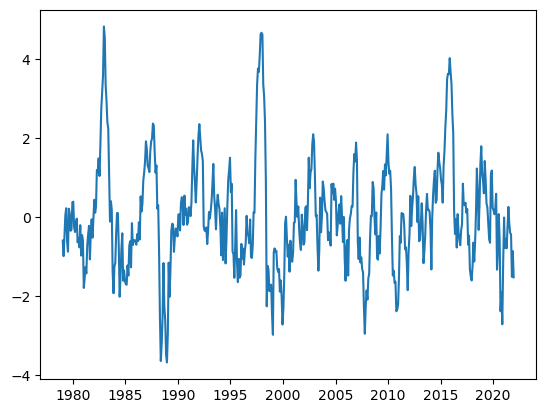

In [35]:
# plot deseasonalized sst at 0, 120W
fig, ax = plt.subplots()
ax.plot(plot_sst_test['time'], plot_sst_test)

#### Plotting Example for Deseasonalized WV Data

In [36]:
# plot deseasonalized wv at 0, 120W
#plot_wv_test = deseasonalized_wv_anom.sel(latitude=0, longitude=240, method="nearest")

#fig, ax = plt.subplots()
#ax.plot(plot_wv_test['time'], plot_wv_test)

### Detrending

In [37]:
# create function to detrend the data
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# -- Running mean
detrended_sst_anom = detrend_dim(deseasonalized_sst_anom,'time',1)
#detrended_wv_anom = detrend_dim(deseasonalized_wv_anom,'time',1)

#### Plotting Example for Detrended SST Data

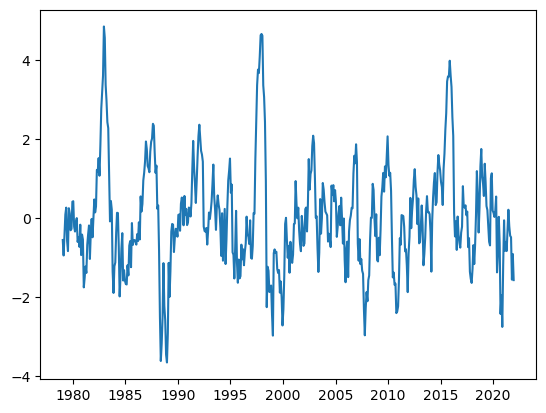

In [38]:
# plot detrended sst anomalies at 0, 120W
plot_sst_test = detrended_sst_anom.sel(latitude=0, longitude=240, method="nearest")
fig, ax = plt.subplots()
ax.plot(plot_sst_test['time'], plot_sst_test)

#### Plotting Example for Detrended WV Data

In [39]:
# plot detrended wv anomalies at 0, 120W
#plot_wv_test = detrended_wv_anom.sel(latitude=0, longitude=240, method="nearest")

#fig, ax = plt.subplots()
#ax.plot(plot_wv_test['time'], plot_wv_test)

### Standardizing

In [40]:
# calculate the standardized sst anomalies
standardized_sst_anom = (detrended_sst_anom - detrended_sst_anom.mean(dim='time'))/ detrended_sst_anom.std(dim='time')
standardized_sst_anom

<xarray.DataArray (time: 516, latitude: 130, longitude: 181)>
array([[[        nan,         nan,         nan, ...,  0.5558299 ,
          0.47730871,  0.39777029],
        [        nan,         nan,         nan, ...,  0.50928989,
          0.48900019,  1.17951225],
        [        nan,         nan,         nan, ...,  0.57007809,
          1.312876  ,  1.85041457],
        ...,
        [ 0.39626474, -0.29210217, -0.30945378, ..., -1.19870894,
         -0.9379211 , -0.18913341],
        [-0.84937301, -1.03310065, -1.27976094, ..., -0.13374514,
          0.23610133,  1.97719439],
        [-1.19556758, -1.23670904, -1.47714054, ..., -0.6025719 ,
         -1.47561357,         nan]],

       [[        nan,         nan,         nan, ...,  0.55404569,
          0.48352817,  0.43026384],
        [        nan,         nan,         nan, ...,  0.51392296,
          0.49405103,  1.00456987],
        [        nan,         nan,         nan, ...,  0.53277942,
          1.40148241,  1.89056941],
...
        [ 0.94932124,  1.12154189,  0.94642181, ...,  1.17536183,
          2.14385976,  2.31884218],
        [-0.21029044,  0.19158614,  0.61669816, ...,  1.88002643,
          1.70392995,  0.70950453],
        [-0.38073389, -0.47441839, -0.57981768, ...,  0.63397772,
          0.15163626,         nan]],

       [[        nan,         nan,         nan, ..., -0.42327975,
         -0.35271547, -0.39263624],
        [        nan,         nan,         nan, ..., -0.39195265,
         -0.40914239, -0.12201221],
        [        nan,         nan,         nan, ..., -0.43269276,
          0.07864327,  0.17264036],
        ...,
        [-0.29186738, -0.11091854, -0.21471238, ..., -0.16434874,
          0.30309209,  0.64782802],
        [ 0.18043916,  0.0653119 ,  0.14954275, ...,  0.17894512,
         -0.26779444, -0.4876336 ],
        [-0.28600809, -0.19303206,  0.07559286, ...,  0.65907031,
          0.75165478,         nan]]])
Coordinates:
  * longitude  (longitude) float32 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime    (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float32 65.0 64.0 63.0 62.0 ... -62.0 -63.0 -64.0

In [41]:
# calculate the standardized wv anomalies
#standardized_wv_anom = (detrended_wv_anom - detrended_wv_anom.mean(dim='time'))/ detrended_wv_anom.std(dim='time')
#standardized_wv_anom

#### Plotting Example for Standardized SST Data

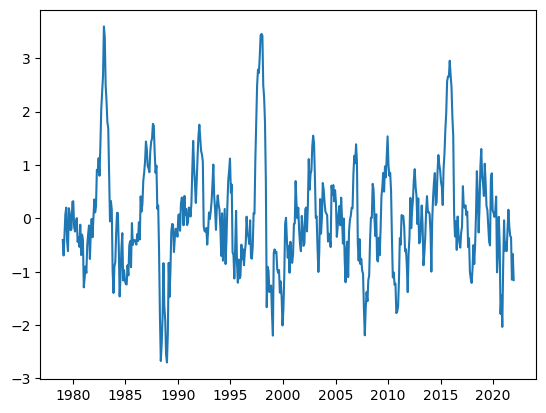

In [42]:
# plot standardized sst anomalies at 0, 120W
plot_sst_test = standardized_sst_anom.sel(latitude=0, longitude=240, method="nearest")

fig, ax = plt.subplots()
ax.plot(plot_sst_test['time'], plot_sst_test)

#### Plotting Example for Standardized WV Data

In [43]:
# plot standardized wv anomalies at 0, 120W
#plot_wv_test = standardized_wv_anom.sel(latitude=0, longitude=240, method="nearest")

#fig, ax = plt.subplots()
#ax.plot(plot_wv_test['time'], plot_wv_test)

## Problem 3

(3) Perform an EOF analysis (with cosine latitude weighting) on the SST anomalies and plot a map of the first 5 EOFs.

### EOF Analysis for the Standardized SST Data

In [44]:
# create an eof solver to do the eof analysis 
coslat = np.cos(np.deg2rad(standardized_sst_anom.coords['latitude'].values))
# square-root of cosine of latitude weights are applied before the computation of eofs
wgts = np.sqrt(coslat)[..., np.newaxis]
solver = Eof(standardized_sst_anom, weights=wgts)

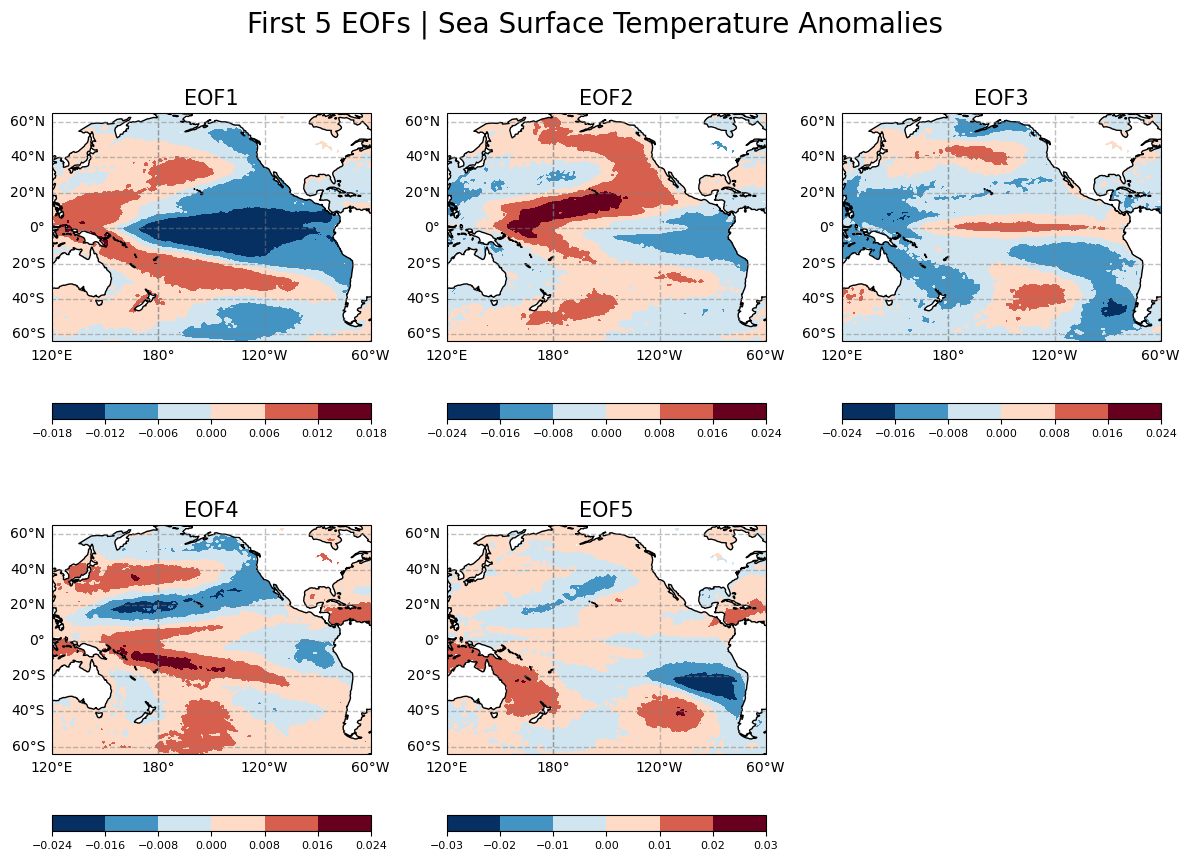

In [45]:
# retrieve first 5 eofs and plot
eofs = solver.eofs(neofs=5)

# set up figure
fig = plt.figure(figsize=(12, 9))
plt.suptitle('First 5 EOFs | Sea Surface Temperature Anomalies', fontsize=20)

# plot first eof
ax1 = plt.subplot(2, 3, 1, projection=ccrs.PlateCarree(central_longitude=190))
fill1 = eofs[0].plot.contourf(ax=ax1, cmap=plt.cm.RdBu_r, add_colorbar=False, transform=ccrs.PlateCarree())
ax1.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
gl = ax1.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',  crs=ccrs.PlateCarree())
gl.top_labels = False
cb = plt.colorbar(fill1, orientation='horizontal')
cb.ax.tick_params(labelsize=8)
ax1.set_title('EOF1', fontsize=15)

# plot second eof
ax2 = plt.subplot(2, 3, 2, projection=ccrs.PlateCarree(central_longitude=190))
fill2 = eofs[1].plot.contourf(ax=ax2, cmap=plt.cm.RdBu_r, add_colorbar=False, transform=ccrs.PlateCarree())
ax2.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
gl = ax2.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',  crs=ccrs.PlateCarree())
gl.top_labels = False
cb = plt.colorbar(fill2, orientation='horizontal')
cb.ax.tick_params(labelsize=8)
ax2.set_title('EOF2', fontsize=15)

# plot third eof
ax3 = plt.subplot(2, 3, 3, projection=ccrs.PlateCarree(central_longitude=190))
fill3 = eofs[2].plot.contourf(ax=ax3, cmap=plt.cm.RdBu_r, add_colorbar=False, transform=ccrs.PlateCarree())
ax3.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
gl = ax3.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',  crs=ccrs.PlateCarree())
gl.top_labels = False
cb = plt.colorbar(fill3, orientation='horizontal')
cb.ax.tick_params(labelsize=8)
ax3.set_title('EOF3', fontsize=15)

# plot fourth eof
ax4 = plt.subplot(2, 3, 4, projection=ccrs.PlateCarree(central_longitude=190))
fill4 = eofs[3].plot.contourf(ax=ax4, cmap=plt.cm.RdBu_r, add_colorbar=False, transform=ccrs.PlateCarree())
ax4.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
gl = ax4.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',  crs=ccrs.PlateCarree())
gl.top_labels = False
cb = plt.colorbar(fill4, orientation='horizontal')
cb.ax.tick_params(labelsize=8)
ax4.set_title('EOF4', fontsize=15)

# plot fifth eof
ax5 = plt.subplot(2, 3, 5, projection=ccrs.PlateCarree(central_longitude=190))
fill5 = eofs[4].plot.contourf(ax=ax5, cmap=plt.cm.RdBu_r, add_colorbar=False, transform=ccrs.PlateCarree())
ax5.add_feature(cfeature.COASTLINE, color='k', edgecolor='k')
gl = ax5.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',  crs=ccrs.PlateCarree())
gl.top_labels = False
cb = plt.colorbar(fill5, orientation='horizontal')
cb.ax.tick_params(labelsize=8)
ax5.set_title('EOF5', fontsize=15)

# adjust figure
plt.subplots_adjust(wspace=0, hspace=0)
plt.tight_layout() 


## Problem 4

(4) Plot the percent of variance explained by the first 10 EOFs.

In [46]:
# create solver to plot percent variance
varfrac = solver.varianceFraction()

(1.380028795520237e-31, 18.29227055822381)

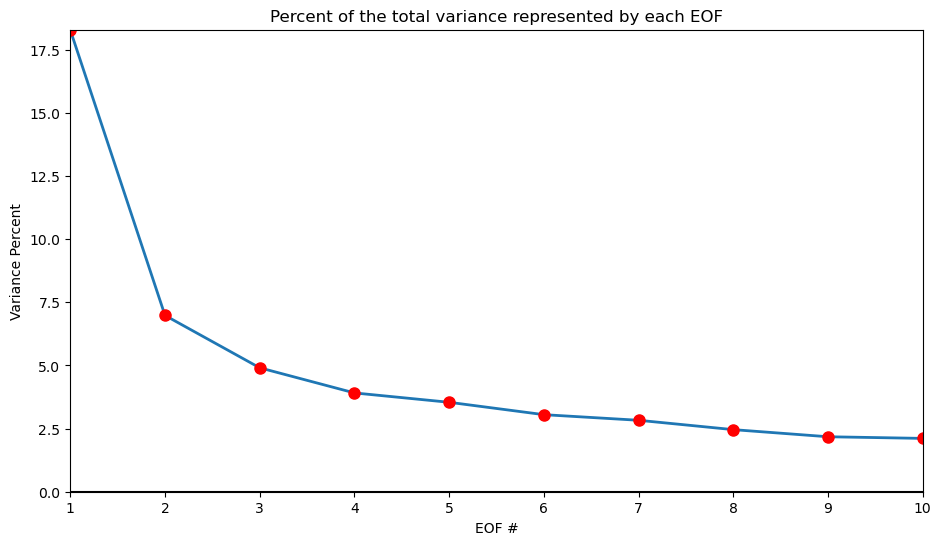

In [47]:
# plot the percent variance for each of the first 10 eofs
plt.figure(figsize=(11,6))
eof_num = range(1, 11)
plt.plot(eof_num, varfrac[0:10]*100, linewidth=2)
plt.plot(eof_num, varfrac[0:10]*100, linestyle='None', marker="o", color='r', markersize=8)
plt.axhline(0, color='k')
plt.xticks(range(1, 11))
plt.title('Percent of the total variance represented by each EOF')
plt.xlabel('EOF #')
plt.ylabel('Variance Percent')
plt.xlim(1, 10)
plt.ylim(np.min(varfrac)*100, np.max(varfrac)*100 + 0.01)

## Problem 5

(5) Reconstruct the SST field using the first 5 EOFs and plot a map of the Pearson's correlation coefficient (xarray.corr) of the reconstructed monthly time series and the "observed" SST time series.

In [48]:
# create solver to reconstruct
reconstruction = solver.reconstructedField(5)
#reconstruction

In [49]:
# rename coordinate to latitude and longitude to match the reconstructed data
sst_ds = sstk_ds.rename({'lat': 'latitude', 'lon':'longitude'})

# round latitudes to match coordinates of the reconstructed data
sst_ds['latitude'] = sst_ds['latitude'].round()
sst_ds

<xarray.DataArray 'Sea_surface_temperature_surface_Mixed_intervals_Average' (
                                                                             time: 516,
                                                                             latitude: 130,
                                                                             longitude: 181)>
[12141480 values with dtype=float32]
Coordinates:
  * longitude  (longitude) float32 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime    (time) datetime64[ns] ...
  * latitude   (latitude) float32 65.0 64.0 63.0 62.0 ... -62.0 -63.0 -64.0
Attributes: (12/15)
    long_name:                       Sea surface temperature (Mixed_intervals...
    units:                           K
    description:                     v-component of wind
    grid_mapping:                    LatLon_Projection
    Grib_Statistical_Interval_Type:  Average
    Grib_Variable_Id:                VAR_98-0-128-34_L1_Imixed_S123
    ...                              ...
    Grib1_Parameter:                 34
    Grib1_Parameter_Name:            sst
    Grib1_Level_Type:                1
    Grib1_Level_Desc:                Ground or water surface
    Grib1_Interval_Type:             123
    Grib1_Interval_Name:             Average of N uninitialized analyses, int...

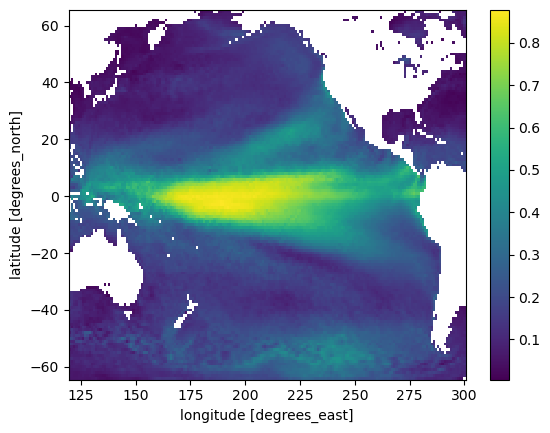

In [50]:
# calculate and plot the correlation between the reconstructed monthly time series and the observed sst time series
correlation = xr.corr(reconstruction, sst_ds, dim='time')
correlation.plot()

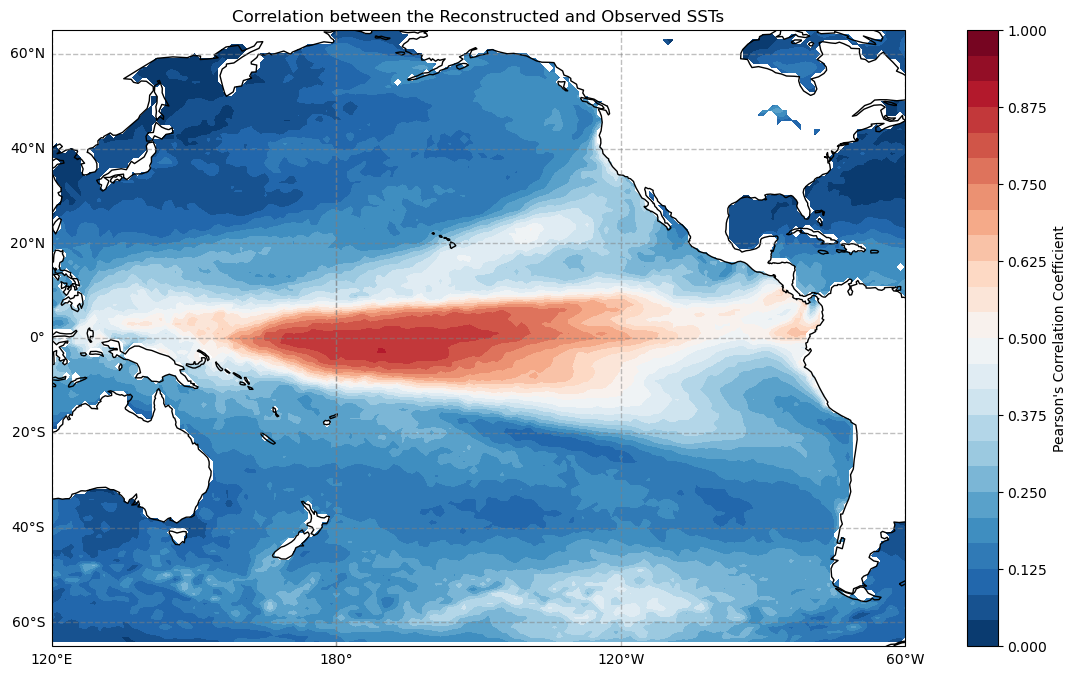

In [51]:
# create nicer correlation plot
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# set the title, add gridlines, features, and set the extent
ax.set_title('Correlation between the Reconstructed and Observed SSTs')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',  crs=ccrs.PlateCarree())
gl.top_labels = False
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([lon_E, lon_W, lat_N, lat_S], crs=ccrs.PlateCarree())

# plot the data
clevs = np.linspace(0, 1, 25)
correlation_cf = ax.contourf(correlation.longitude, correlation.latitude, correlation, levels=clevs, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)

# specify the colorbar
cbar = plt.colorbar(correlation_cf)
cbar.set_label("Pearson's Correlation Coefficient") 

## Problem 6

(6) Compute a map of the Pearson's correlation coefficient between SST EOF1 and monthly mean detrended, deseasonalized, and standardized monthly mean column water vapor anomalies (don't mask these over land for the plot). See anything interesting?

### Deseasonalize, Detrend, and Standardize WV Data

In [52]:
# compute deseasonalized wv anomalies (using unmasked wv anomalies computed in part 1)
wv_anom_grouped = wv_anomaly.groupby('time.month')
wv_anom_monthly_mean = wv_anom_grouped.mean(dim='time')
deseasonalized_wv_anom = wv_anom_grouped - wv_anom_monthly_mean
deseasonalized_wv_anom

<xarray.DataArray 'Total_column_water_vapour_surface_Mixed_intervals_Average' (
                                                                               time: 516,
                                                                               latitude: 130,
                                                                               longitude: 181)>
array([[[-0.84616476, -0.7800083 , -0.708265  , ...,  1.3655223 ,
          1.4234117 ,  1.4801432 ],
        [-0.9114582 , -0.8559531 , -0.79706407, ...,  1.3566875 ,
          1.4274769 ,  1.4940194 ],
        [-0.9383704 , -0.8717598 , -0.8120078 , ...,  1.4002694 ,
          1.4743065 ,  1.5318102 ],
        ...,
        [-1.0893518 , -1.1195116 , -1.1979091 , ...,  0.8411079 ,
          0.7272589 ,  0.5954003 ],
        [-1.2028373 , -1.2145561 , -1.2044271 , ...,  0.5412351 ,
          0.42132232,  0.27924383],
        [-1.1670225 , -1.1710196 , -1.1583697 , ...,  0.5177749 ,
          0.35884503,  0.25274035]],

       [[-0.6710859 , -0.64024466, -0.6045888 , ...,  0.7332791 ,
          0.89888597,  1.0363996 ],
        [-0.6109478 , -0.5870561 , -0.56375486, ...,  0.88616794,
          1.1147063 ,  1.3690213 ],
        [-0.50316256, -0.48756027, -0.47697705, ...,  1.1525878 ,
          1.4692439 ,  1.7221736 ],
...
        [-1.2091398 , -1.1922203 , -1.1621968 , ...,  0.41767702,
          0.41286233,  0.41338465],
        [-1.1773221 , -1.1702363 , -1.1587675 , ...,  0.5992949 ,
          0.6074481 ,  0.5325253 ],
        [-1.1311965 , -1.1300837 , -1.0917252 , ...,  0.6558674 ,
          0.41227186,  0.1795093 ]],

       [[-0.4264878 , -0.42596546, -0.416109  , ...,  1.0607942 ,
          1.1241573 ,  1.2514284 ],
        [-0.439978  , -0.45378613, -0.45660228, ...,  0.9519643 ,
          1.0364484 ,  1.1419853 ],
        [-0.42676035, -0.4290541 , -0.4317794 , ...,  0.8743617 ,
          0.97606045,  1.0469633 ],
        ...,
        [ 0.61059856,  0.65009254,  0.63957745, ...,  0.3463362 ,
          0.35433036,  0.36339197],
        [ 0.66998714,  0.5299072 ,  0.34663144, ...,  0.37143156,
          0.34778967,  0.30239087],
        [ 0.05155103, -0.11937012, -0.30548477, ...,  0.46949664,
          0.34629118,  0.13480863]]], dtype=float32)
Coordinates:
  * longitude  (longitude) float32 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime    (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float32 65.0 64.0 63.0 62.0 ... -62.0 -63.0 -64.0

In [53]:
# create function to detrend the data
def detrend_dim(da, dim, deg=1):
    # detrend along a single dimension
    p = da.polyfit(dim=dim, deg=deg)
    fit = xr.polyval(da[dim], p.polyfit_coefficients)
    return da - fit

# -- Running mean
#detrended_sst_anom = detrend_dim(deseasonalized_sst_anom,'time',1)
detrended_wv_anom = detrend_dim(deseasonalized_wv_anom,'time',1)

In [54]:
# calculate the standardized wv anomalies
standardized_wv_anom = (detrended_wv_anom - detrended_wv_anom.mean(dim='time'))/ detrended_wv_anom.std(dim='time')
standardized_wv_anom

<xarray.DataArray (time: 516, latitude: 130, longitude: 181)>
array([[[-0.43934486, -0.38509053, -0.32824336, ...,  1.4940014 ,
          1.53735275,  1.57355073],
        [-0.49185983, -0.4445045 , -0.39463076, ...,  1.4463535 ,
          1.48613112,  1.51814694],
        [-0.5266825 , -0.48670058, -0.45257518, ...,  1.42224357,
          1.46417979,  1.49733771],
        ...,
        [-1.61762398, -1.64128237, -1.72273634, ...,  1.04342353,
          0.91810497,  0.7793181 ],
        [-1.69568802, -1.69982747, -1.67437244, ...,  0.71660008,
          0.58317161,  0.43481692],
        [-1.60241198, -1.60610633, -1.58767184, ...,  0.70409451,
          0.64973651,  0.60899537]],

       [[-0.29435812, -0.27047074, -0.24354564, ...,  0.96168377,
          1.09760736,  1.20533638],
        [-0.25011607, -0.23163542, -0.21184102, ...,  1.05905271,
          1.23165156,  1.4173189 ],
        [-0.17365265, -0.17476809, -0.17863578, ...,  1.22351396,
          1.45905139,  1.64362529],
...
        [-1.47435516, -1.44405984, -1.396705  , ...,  0.4089203 ,
          0.40213319,  0.40189688],
        [-1.37533288, -1.36659789, -1.35006075, ...,  0.60659021,
          0.60894009,  0.51767315],
        [-1.26849469, -1.26274232, -1.20685849, ...,  0.65590378,
          0.53238929,  0.29265407]],

       [[-0.62189927, -0.61241825, -0.60084458, ...,  0.54376159,
          0.5920304 ,  0.68491611],
        [-0.5994711 , -0.59670248, -0.59232459, ...,  0.4477629 ,
          0.50873703,  0.58207409],
        [-0.58351134, -0.57231487, -0.56743195, ...,  0.3922218 ,
          0.46330422,  0.50015153],
        ...,
        [ 0.97374015,  1.01491175,  0.98491576, ...,  0.3263403 ,
          0.33407253,  0.34305377],
        [ 1.00831883,  0.81966108,  0.57676266, ...,  0.34195384,
          0.30777387,  0.24734008],
        [ 0.20926574, -0.00232692, -0.22999112, ...,  0.43959593,
          0.43088393,  0.19912336]]])
Coordinates:
  * longitude  (longitude) float32 120.0 121.0 122.0 123.0 ... 298.0 299.0 300.0
  * time       (time) datetime64[ns] 1979-01-16T12:00:00 ... 2021-12-16T12:00:00
    reftime    (time) datetime64[ns] 1979-01-01 1979-02-01 ... 2021-12-01
    month      (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
  * latitude   (latitude) float32 65.0 64.0 63.0 62.0 ... -62.0 -63.0 -64.0

### Compute Pearson's Correlation Coefficient Maps

In [55]:
# retrieve first sst eof
reconstructed_eof1 = solver.reconstructedField(1)

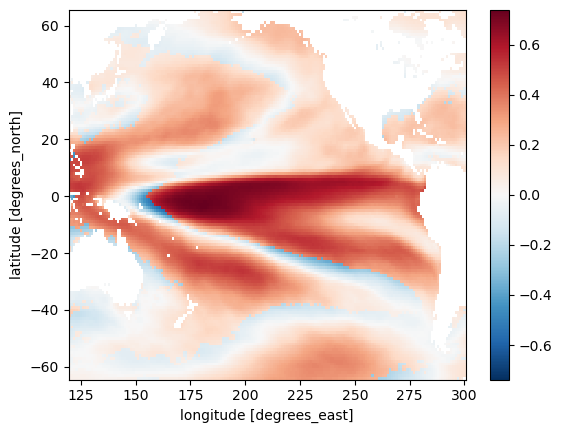

In [56]:
# calculate and plot the correlation between the sst eof 1 and the deseasonalized monthly mean wv anomalies
eof1_corr_deseason_wv = xr.corr(reconstructed_eof1, deseasonalized_wv_anom, dim='time')
eof1_corr_deseason_wv.plot()

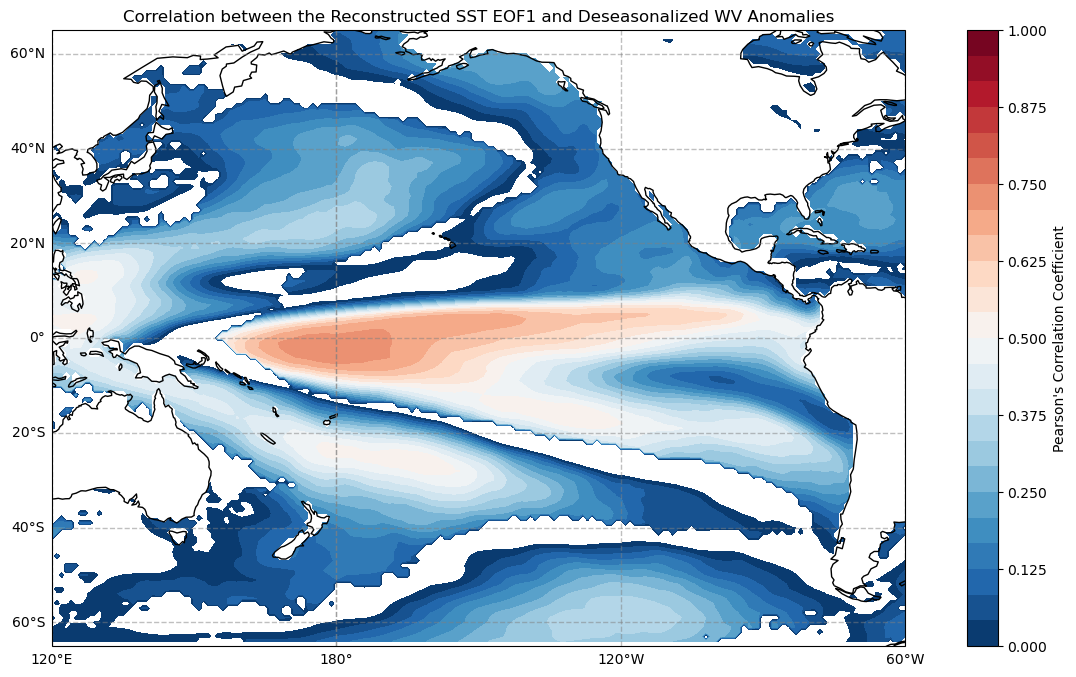

In [57]:
# create nicer correlation plot
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# set the title, add gridlines, features, and set the extent
ax.set_title('Correlation between the Reconstructed SST EOF1 and Deseasonalized WV Anomalies')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',  crs=ccrs.PlateCarree())
gl.top_labels = False
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([lon_E, lon_W, lat_N, lat_S], crs=ccrs.PlateCarree())

# plot the data
clevs = np.linspace(0, 1, 25)
correlation_cf = ax.contourf(eof1_corr_deseason_wv.longitude, eof1_corr_deseason_wv.latitude, eof1_corr_deseason_wv, levels=clevs, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)

# specify the colorbar
cbar = plt.colorbar(correlation_cf)
cbar.set_label("Pearson's Correlation Coefficient") 

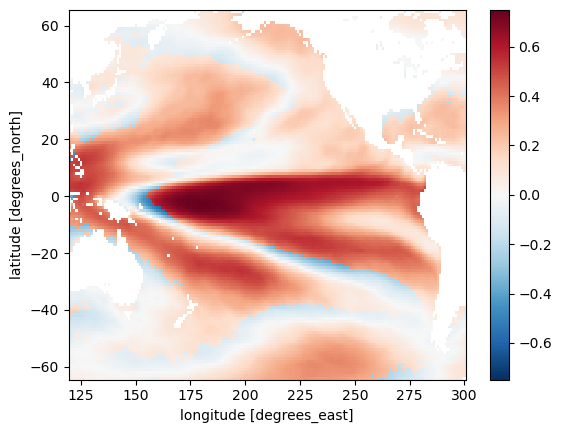

In [58]:
# calculate and plot the correlation between the sst eof 1 and the detrended monthly mean wv anomalies
eof1_corr_detrend_wv = xr.corr(reconstructed_eof1, detrended_wv_anom, dim='time')
eof1_corr_detrend_wv.plot()

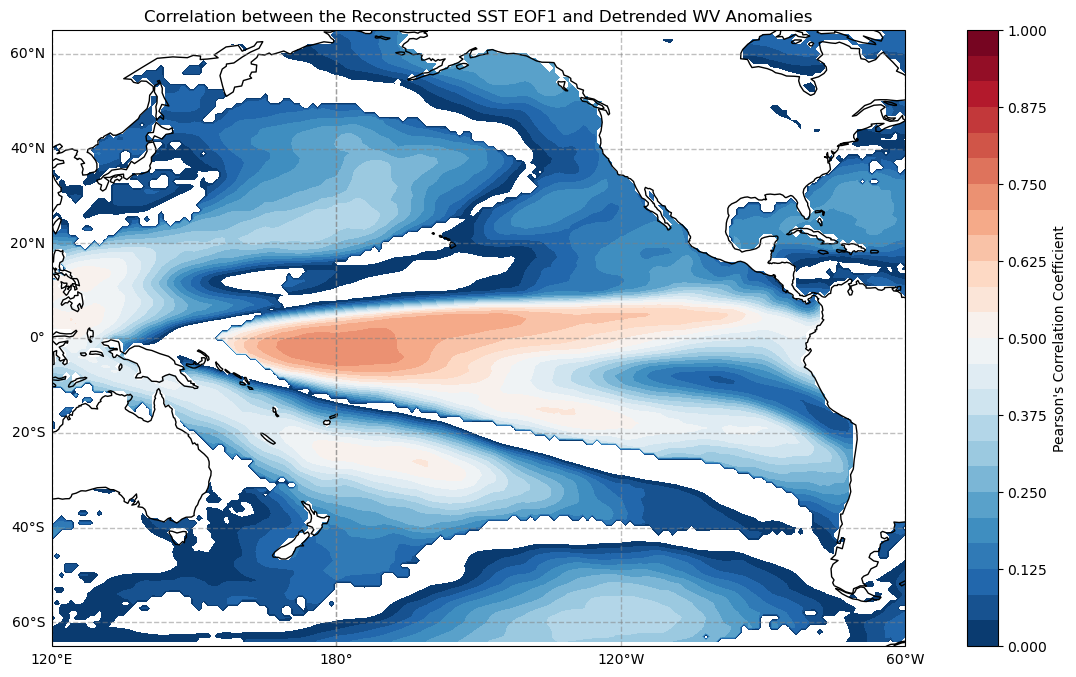

In [59]:
# create nicer correlation plot
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# set the title, add gridlines, features, and set the extent
ax.set_title('Correlation between the Reconstructed SST EOF1 and Detrended WV Anomalies')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',  crs=ccrs.PlateCarree())
gl.top_labels = False
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([lon_E, lon_W, lat_N, lat_S], crs=ccrs.PlateCarree())

# plot the data
clevs = np.linspace(0, 1, 25)
correlation_cf = ax.contourf(eof1_corr_detrend_wv.longitude, eof1_corr_detrend_wv.latitude, eof1_corr_detrend_wv, levels=clevs, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)

# specify the colorbar
cbar = plt.colorbar(correlation_cf)
cbar.set_label("Pearson's Correlation Coefficient")

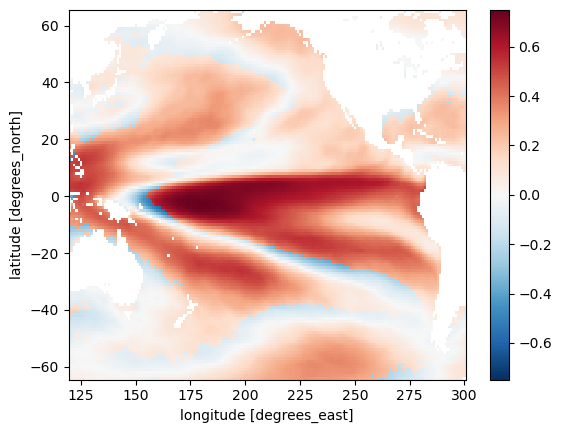

In [60]:
# calculate and plot the correlation between the sst eof 1 and the standardized monthly mean wv anomalies
eof1_corr_standard_wv = xr.corr(reconstructed_eof1, standardized_wv_anom, dim='time')
eof1_corr_standard_wv.plot()

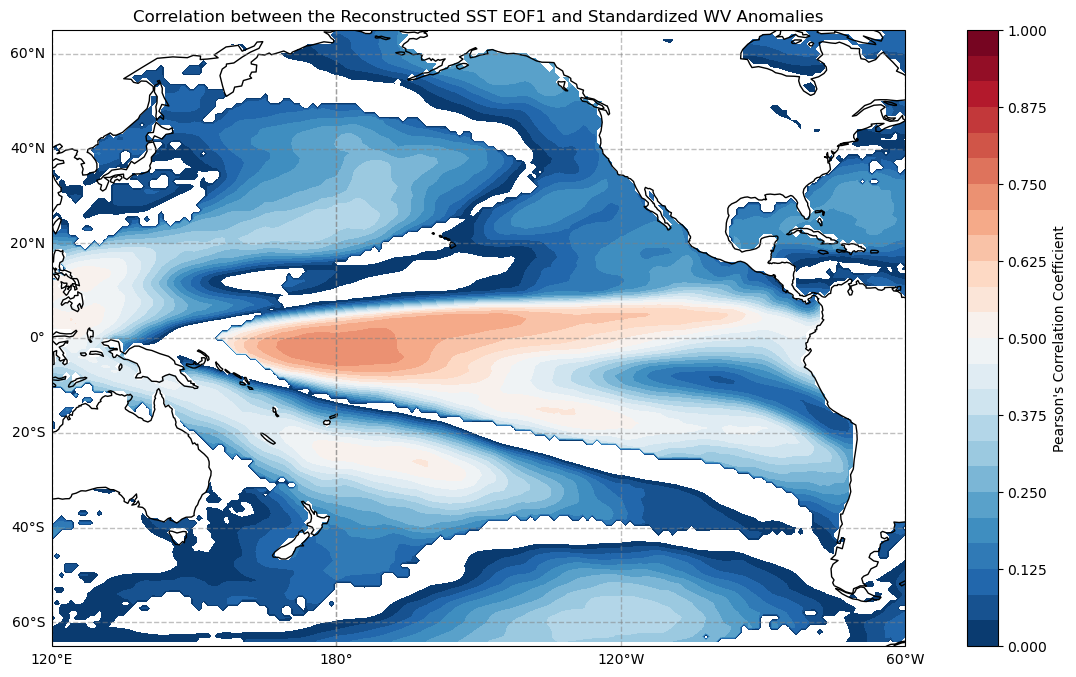

In [61]:
# create nicer correlation plot
fig, ax = plt.subplots(figsize=(16, 8), subplot_kw={'projection': ccrs.PlateCarree(central_longitude=180)})

# set the title, add gridlines, features, and set the extent
ax.set_title('Correlation between the Reconstructed SST EOF1 and Standardized WV Anomalies')
gl = ax.gridlines(draw_labels=True, linewidth=1, color='gray', alpha=0.5, linestyle='--',  crs=ccrs.PlateCarree())
gl.top_labels = False
ax.add_feature(cfeature.COASTLINE)
ax.set_extent([lon_E, lon_W, lat_N, lat_S], crs=ccrs.PlateCarree())

# plot the data
clevs = np.linspace(0, 1, 25)
correlation_cf = ax.contourf(eof1_corr_standard_wv.longitude, eof1_corr_standard_wv.latitude, eof1_corr_standard_wv, levels=clevs, transform=ccrs.PlateCarree(), cmap=plt.cm.RdBu_r)

# specify the colorbar
cbar = plt.colorbar(correlation_cf)
cbar.set_label("Pearson's Correlation Coefficient")